# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://2abf04f86c87:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 00:39:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Build schema
from luis_gonzalez.spark_utils import SparkUtils

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])

df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")

In [4]:
from pyspark.sql.functions import get_json_object

df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name"))

In [5]:
schema_agencies = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

df_rental = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

In [6]:
##Extract agency_id
df_rental = df_rental.withColumn("agency_id", get_json_object(df_rental.rental_info, "$.agency_id"))
df_rental = df_rental.withColumn("car_id", get_json_object(df_rental.rental_info, "$.car_id"))
df_rental = df_rental.withColumn("customer_id", get_json_object(df_rental.rental_info, "$.customer_id"))

In [7]:
schema_agencies = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])

df_car = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")

In [8]:
df_car = df_car.withColumn("car_name", get_json_object(df_car.car_info, "$.car_name"))

In [9]:
schema_agencies = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])

df_customer = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")


In [10]:
df_customer = df_customer.withColumn("customer_name", get_json_object(df_customer.customer_info, "$.customer_name"))

In [11]:
customer_to_join = df_customer.select("customer_id", "customer_name")
df_final = df_rental.join(customer_to_join, on="customer_id", how="left")

car_to_join = df_car.select("car_id", "car_name")
df_final = df_final.join(car_to_join, on="car_id", how="left")

agency_to_join = df_agencies.select("agency_id", "agency_name")
df_final = df_final.join(agency_to_join, on="agency_id", how="left")


In [12]:
df_car_rentals = df_final.select("rental_id", "customer_name", "car_name", "agency_name")

df_car_rentals.show()

+---------+---------------+--------------------+-------------+
|rental_id|  customer_name|            car_name|  agency_name|
+---------+---------------+--------------------+-------------+
|    11891| Margaret Jones|Wallace-Carlson M...|  NYC Rentals|
|    11892|Albert Williams|Grimes-Green Model 8|LA Car Rental|
|    11893|  Caleb Fleming|Stewart-Allen Mod...|      SF Cars|
|    11894|  Andrew Butler|  Campos PLC Model 4|  NYC Rentals|
|    11895|  Kristin Potts|  Wagner LLC Model 1|      SF Cars|
|    11896|   Jeremy Parks|Jones, Jefferson ...|LA Car Rental|
|    11897|    Terry Wells|Lopez and Sons Mo...| Zapopan Auto|
|    11898|  Marc Williams| Salazar Ltd Model 8|      SF Cars|
|    11899| Danny Williams|Villanueva PLC Mo...|LA Car Rental|
|    11900| Eric Owens PhD|Faulkner-Howard M...|      SF Cars|
|    11901|    Laura Perry|Faulkner-Howard M...|  NYC Rentals|
|    11902|     Paul Brown|Faulkner-Howard M...|  NYC Rentals|
|    11903|Alexa Hernandez|Atkinson Ltd Mode...| Zapopa

In [35]:
!pwd
base_path = "/opt/spark/work-dir/data/"

/opt/spark/work-dir/labs/lab04


In [39]:
!du -sh /opt/spark/work-dir/data/car_service/rentals/


1.1M	/opt/spark/work-dir/data/car_service/rentals/


In [37]:
df_car_rentals.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [40]:
!du -sh /opt/spark/work-dir/data/car_service/output/parquet/

180K	/opt/spark/work-dir/data/car_service/output/parquet/


In [41]:
df_car_rentals.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

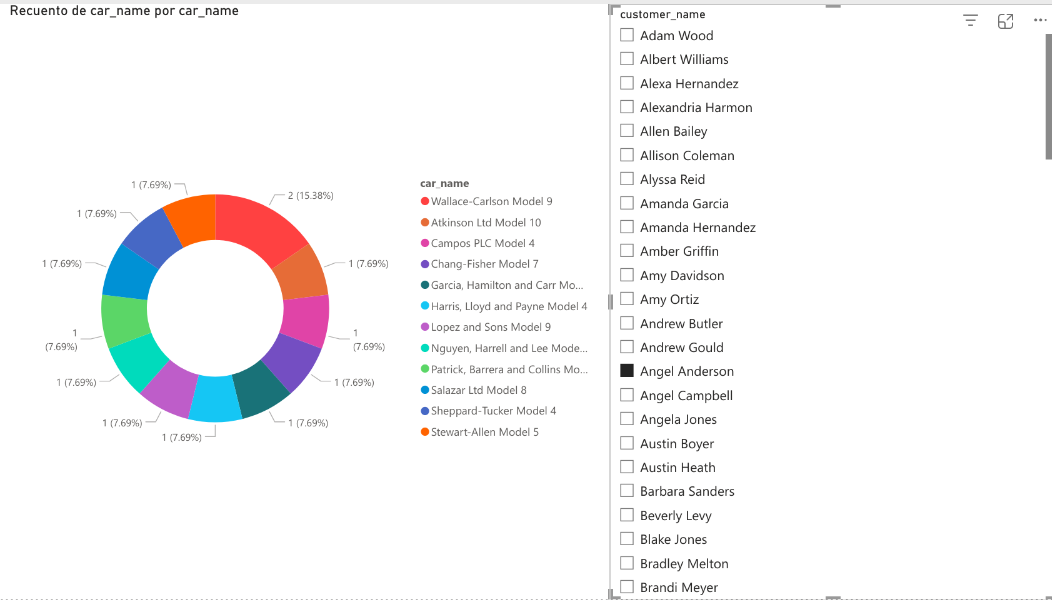

In [ ]:
sc.stop()